En este notebook la diferencia que hay con respecto al anterior es que estamos haciendo uso del optimizador que usa el artículo de voets, con los parámetros que usan en dicho artículo, aunque manteniendo la misma función de error de los anteriores notebooks, ya que la función de error del artículo de voets está diseñada para una salida sigmoide de la red.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join( 'train8k_2cat')
test_dir = os.path.join('test2k_2cat')


In [3]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
#train_2 = os.path.join(train_dir, '2') 
#train_3 = os.path.join(train_dir, '3')  
#train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
#val_2 = os.path.join(val_dir, '2') 
#val_3 = os.path.join(val_dir, '3')  
#val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
#num_2_tr = len(os.listdir(train_2))
#num_3_tr = len(os.listdir(train_3))
#num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
#num_2_v = len(os.listdir(val_2))
#num_3_v = len(os.listdir(val_3))
#num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr #+ num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v #+ num_2_v + num_3_v + num_4_v
 

In [4]:

def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float32)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float32)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

def augment_pre(image):
    
    augmentation=True
    
    BRIGHTNESS_MAX_DELTA = 0.125
    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5
    HUE_MAX_DELTA = 0.2
    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    image = rescale_min_1_to_1(image)

    # Apply data augmentations randomly.
    augmentations = [
        {'fn': tf.image.random_flip_left_right},
        {'fn': tf.image.random_brightness,
         'args': [BRIGHTNESS_MAX_DELTA]},
        {'fn': tf.image.random_saturation,
         'args': [SATURATION_LOWER, SATURATION_UPPER]},
        {'fn': tf.image.random_hue,
         'args': [HUE_MAX_DELTA]},
        {'fn': tf.image.random_contrast,
         'args': [CONTRAST_LOWER, CONTRAST_UPPER]}]

    shuffle(augmentations)

    if augmentation:
        for aug in augmentations:
            if 'args' in aug:
                image = aug['fn'](image, *aug['args'])
            else:
                image = aug['fn'](image)
    return image

In [5]:
img_height=299
img_width=299
batch_size=32


In [6]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='sparse'
                                                     )

Found 4362 images belonging to 2 classes.


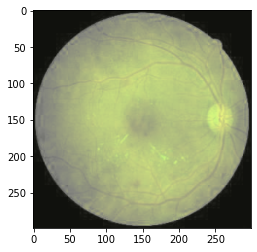

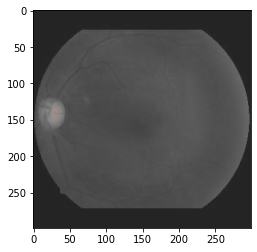

In [7]:

x,y= train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow((image+1)/2)
    plt.show()

In [8]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='sparse'
                                                  )

Found 1024 images belonging to 2 classes.


In [9]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='avg'),
        tf.keras.layers.Dense(2,activation='softmax')
    ])
    
    



    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-4,decay=4e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [10]:
with tf.device('/GPU:0'):
    epochs=200
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size)))
    )

Train for 137 steps, validate for 32 steps
Epoch 1/200
137/137 [==============================] - 134s 980ms/step - loss: 0.6717 - accuracy: 0.5915 - val_loss: 0.6890 - val_accuracy: 0.5918
Epoch 2/200
137/137 [==============================] - 116s 844ms/step - loss: 0.6287 - accuracy: 0.6566 - val_loss: 0.6791 - val_accuracy: 0.5947
Epoch 3/200
137/137 [==============================] - 115s 836ms/step - loss: 0.5949 - accuracy: 0.6988 - val_loss: 0.7278 - val_accuracy: 0.5762
Epoch 4/200
137/137 [==============================] - 115s 836ms/step - loss: 0.5706 - accuracy: 0.7221 - val_loss: 0.6725 - val_accuracy: 0.6172
Epoch 5/200
137/137 [==============================] - 115s 840ms/step - loss: 0.5383 - accuracy: 0.7570 - val_loss: 0.6690 - val_accuracy: 0.6191
Epoch 6/200
137/137 [==============================] - 117s 854ms/step - loss: 0.5106 - accuracy: 0.7891 - val_loss: 0.6722 - val_accuracy: 0.6074
Epoch 7/200
137/137 [==============================] - 117s 854ms/step - lo

137/137 [==============================] - 114s 835ms/step - loss: 0.3263 - accuracy: 0.9867 - val_loss: 0.6819 - val_accuracy: 0.6230
Epoch 57/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3280 - accuracy: 0.9851 - val_loss: 0.7003 - val_accuracy: 0.6035
Epoch 58/200
137/137 [==============================] - 114s 836ms/step - loss: 0.3318 - accuracy: 0.9810 - val_loss: 0.7414 - val_accuracy: 0.5605
Epoch 59/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3261 - accuracy: 0.9865 - val_loss: 0.6951 - val_accuracy: 0.6006
Epoch 60/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3280 - accuracy: 0.9853 - val_loss: 0.7038 - val_accuracy: 0.5996
Epoch 61/200
137/137 [==============================] - 115s 839ms/step - loss: 0.3287 - accuracy: 0.9842 - val_loss: 0.7214 - val_accuracy: 0.5859
Epoch 62/200
137/137 [==============================] - 115s 837ms/step - loss: 0.3277 - accuracy: 0.9853 - val_loss: 0.7127 

137/137 [==============================] - 114s 833ms/step - loss: 0.3206 - accuracy: 0.9924 - val_loss: 0.6744 - val_accuracy: 0.6348
Epoch 112/200
137/137 [==============================] - 114s 833ms/step - loss: 0.3195 - accuracy: 0.9940 - val_loss: 0.6808 - val_accuracy: 0.6191
Epoch 113/200
137/137 [==============================] - 114s 834ms/step - loss: 0.3193 - accuracy: 0.9940 - val_loss: 0.6943 - val_accuracy: 0.6074
Epoch 114/200
137/137 [==============================] - 114s 834ms/step - loss: 0.3193 - accuracy: 0.9940 - val_loss: 0.6967 - val_accuracy: 0.6025
Epoch 115/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3192 - accuracy: 0.9943 - val_loss: 0.6827 - val_accuracy: 0.6230
Epoch 116/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3186 - accuracy: 0.9945 - val_loss: 0.6660 - val_accuracy: 0.6377
Epoch 117/200
137/137 [==============================] - 115s 836ms/step - loss: 0.3206 - accuracy: 0.9927 - val_loss: 0

137/137 [==============================] - 114s 835ms/step - loss: 0.3174 - accuracy: 0.9959 - val_loss: 0.7006 - val_accuracy: 0.6055
Epoch 167/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3181 - accuracy: 0.9952 - val_loss: 0.6919 - val_accuracy: 0.6143
Epoch 168/200
137/137 [==============================] - 114s 836ms/step - loss: 0.3177 - accuracy: 0.9956 - val_loss: 0.6957 - val_accuracy: 0.6104
Epoch 169/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3174 - accuracy: 0.9959 - val_loss: 0.6955 - val_accuracy: 0.6074
Epoch 170/200
137/137 [==============================] - 114s 834ms/step - loss: 0.3167 - accuracy: 0.9966 - val_loss: 0.7048 - val_accuracy: 0.6025
Epoch 171/200
137/137 [==============================] - 114s 836ms/step - loss: 0.3180 - accuracy: 0.9954 - val_loss: 0.6857 - val_accuracy: 0.6230
Epoch 172/200
137/137 [==============================] - 114s 835ms/step - loss: 0.3176 - accuracy: 0.9954 - val_loss: 0

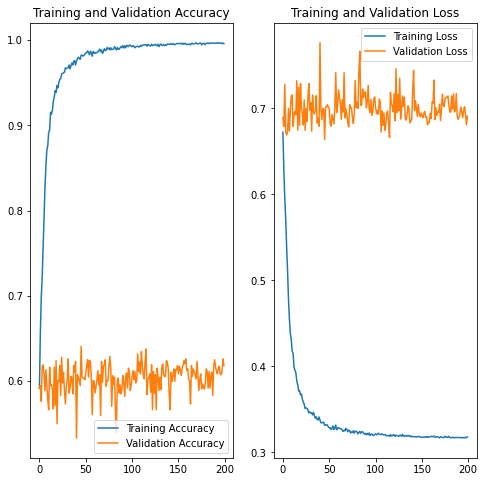

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Mantenemos resultados nefastos para el set de validación, aunque el nuevo optimizador con los nuevos parámetros proporciona un aprendizaje más rápido en el set de entrenamiento.

In [12]:
# Guardar el Modelo
model.save('miniprueba5.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')